# Pneumonia Image Classification 

## Business Understanding:

In this image classification project, I am utilizing neural networks - primarily convolutional neural networks - to create a model that can identify whether or not a patient has pneumonia by analyzing their lung x-rays. 

There are two types of pneumonia - bacterial and viral. The image classification system will have to be able to pick out both, while not necessarily knowing which one is which, as the types of pneumonia are not labeled in the dataset. 



## Data Understanding:
The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care. 

Due to the relatively small amount of validation data (16 images), as well as test data, I will create my own validation data instead of using the provided split.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten
from sklearn.preprocessing import StandardScaler, LabelBinarizer
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
import tensorflow as tf
from keras import models
from keras import layers
import pathlib
import PIL
import seaborn as sns
import time
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from sklearn.model_selection import train_test_split, cross_val_score
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
import shutil
import random
import glob
import os
import sys
import itertools
import warnings
import statistics

## Check Data

In [2]:
train_norm_size = len(os.listdir('re-split_data/train/normal'))
train_pneum_size = len(os.listdir('re-split_data/train/pneumonia'))
test_norm_size = len(os.listdir('re-split_data/test/normal'))
test_pneum_size = len(os.listdir('re-split_data/test/pneumonia'))
valid_norm_size = len(os.listdir('re-split_data/validation/normal'))
valid_pneum_size = len(os.listdir('re-split_data/validation/pneumonia'))


train_size = train_norm_size + train_pneum_size -1
test_size = test_norm_size + test_pneum_size -1
validation_size = valid_norm_size + valid_pneum_size

print(f' There are {train_size} images in the training set, {test_size} in the test set, and {validation_size} in the validation set')

print(f'train norm is {train_norm_size}')
print(f'train pneum is {train_pneum_size}')
print(f'test norm: {test_norm_size}')
print(f'test pneum: {test_pneum_size}')
print(f'valid norm: {valid_norm_size}')
print(f'valid pneum: {valid_pneum_size}')


 There are 3271 images in the training set, 1751 in the test set, and 816 in the validation set
train norm is 882
train pneum is 2390
test norm: 473
test pneum: 1279
valid norm: 220
valid pneum: 596


### Add Functions

In [3]:
# Define Result Saving Initial Function
dfcols = ['model_name', 'Train Accuracy', 'Test Accuracy', 'CV1', 'CV2', 'CV3', 'CV4', 'CV5', 'CV_Std', 'CV_avg']
model_summary = pd.DataFrame(columns=dfcols)


def save_result(model_name, Train_Accuracy, Test_Accuracy, cv1, cv2, cv3, cv4, cv5):
            global model_summary
            cv_std = statistics.stdev([cv1, cv2, cv3, cv4, cv5])
            cv_avg = (cv1 + cv2 + cv3 + cv4 + cv5) / 5
            row = [(model_name, Train_Accuracy, Test_Accuracy, cv1, cv2, cv3, cv4, cv5, cv_std, cv_avg)]
            res = pd.DataFrame(columns = dfcols, data = row)
            yeep = [model_summary, res]
            model_summary = pd.concat(yeep)
            model_summary = model_summary.sort_values('CV_avg', ascending = False)
            model_summary = model_summary.drop_duplicates()
            return model_summary.round(3)

In [132]:
# SOURCE: The origin of this confusion matrix code was found on medium, '
# from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            a = cf[0,0]
            b = cf[0,1]
            c = cf[1,0]
            d = cf[1,1]
            tn = ((a / (a+b))*100).round(2).astype(str) + '%'
            fp = ((b / (a+b))*100).round(2).astype(str) + '%'
            fn = ((c / (c+d))*100).round(2).astype(str) + '%'
            tp = ((d / (c+d))*100).round(2).astype(str) + '%'
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages =  [tn,fp,fn,tp]
        # old = group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label', weight = 'bold')
        plt.xlabel('Predicted label' + stats_text, weight = 'bold')
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title,size = 20, weight = 'bold')

### Re-Splitting (Hide)

#### Check re-aggregated images

Due to the issues with the given train/test split, i re-aggregated the images. From here, I will train/test split the data myself. 

In [4]:
'''
folder = 're-split_data/NORMAL'
path = folder

p = os.listdir(path)
pf = pd.DataFrame(p)

norm_tot = len(pf)
print(f' There are {len(pf[0])} images in the normal folder')
folder = 're-split_data/PNEUMONIA'
path = folder
p = os.listdir(path)
pf = pd.DataFrame(p)
pneum_tot = len(pf)
pneum_weight = len(pf) / 5863
norm_weight = 1 - pneum_weight
pf
print(f' There are {len(pf[0])} images in the pneumonia folder')
print(f' there are {1576 + len(pf[0])} total images in the dataset')
print(f' The weight of pneumonia is {round(pneum_weight,2)}')
print(f' The weight of normal is {round(norm_weight,2)}')

'''

"\nfolder = 're-split_data/NORMAL'\npath = folder\n\np = os.listdir(path)\npf = pd.DataFrame(p)\n\nnorm_tot = len(pf)\nprint(f' There are {len(pf[0])} images in the normal folder')\nfolder = 're-split_data/PNEUMONIA'\npath = folder\np = os.listdir(path)\npf = pd.DataFrame(p)\npneum_tot = len(pf)\npneum_weight = len(pf) / 5863\nnorm_weight = 1 - pneum_weight\npf\nprint(f' There are {len(pf[0])} images in the pneumonia folder')\nprint(f' there are {1576 + len(pf[0])} total images in the dataset')\nprint(f' The weight of pneumonia is {round(pneum_weight,2)}')\nprint(f' The weight of normal is {round(norm_weight,2)}')\n\n"

From here, there is some code which I used to re-split the data.

In [5]:
# define test and train split percentages
'''
norm_train = norm_tot * .7
norm_test = norm_tot * .3
pneum_train = pneum_tot * .7
pneum_test = pneum_tot * .3
'''

'''
pf = os.listdir('re-split_data/NORMAL')
rand_norm_files = random.sample(pf, int(norm_train))
for file in rand_norm_files:
    shutil.copy('re-split_data/NORMAL/' + file, 're-split_data/train/normal')
'''

"\npf = os.listdir('re-split_data/NORMAL')\nrand_norm_files = random.sample(pf, int(norm_train))\nfor file in rand_norm_files:\n    shutil.copy('re-split_data/NORMAL/' + file, 're-split_data/train/normal')\n"

In [6]:
'''
p1 = os.listdir('re-split_data/train/normal')
p1 = pd.DataFrame(p1)

p2 = os.listdir('re-split_data/NORMAL')
p2 = pd.DataFrame(p2)

tester_files = pd.concat([p1[0],p2[0]]).drop_duplicates(keep=False)
'''

"\np1 = os.listdir('re-split_data/train/normal')\np1 = pd.DataFrame(p1)\n\np2 = os.listdir('re-split_data/NORMAL')\np2 = pd.DataFrame(p2)\n\ntester_files = pd.concat([p1[0],p2[0]]).drop_duplicates(keep=False)\n"

In [7]:
#for file in tester_files:
    #shutil.copy('re-split_data/NORMAL/' + file, 're-split_data/test/normal')

In [8]:
'''
# The pneumonia files
pf = os.listdir('re-split_data/PNEUMONIA')

rand_Pfiles = random.sample(pf, int(pneum_train))

for file in rand_Pfiles:
    shutil.copy('re-split_data/PNEUMONIA/' + file, 're-split_data/train/pneumonia')

p3 = os.listdir('re-split_data/train/pneumonia')
p3 = pd.DataFrame(p3)

p4 = os.listdir('re-split_data/PNEUMONIA')
p4 = pd.DataFrame(p4)

tester_p =  pd.concat([p3[0],p4[0]]).drop_duplicates(keep=False)

for file in tester_p:
    shutil.copy('re-split_data/PNEUMONIA/' + file, 're-split_data/test/pneumonia')

'''

"\n# The pneumonia files\npf = os.listdir('re-split_data/PNEUMONIA')\n\nrand_Pfiles = random.sample(pf, int(pneum_train))\n\nfor file in rand_Pfiles:\n    shutil.copy('re-split_data/PNEUMONIA/' + file, 're-split_data/train/pneumonia')\n\np3 = os.listdir('re-split_data/train/pneumonia')\np3 = pd.DataFrame(p3)\n\np4 = os.listdir('re-split_data/PNEUMONIA')\np4 = pd.DataFrame(p4)\n\ntester_p =  pd.concat([p3[0],p4[0]]).drop_duplicates(keep=False)\n\nfor file in tester_p:\n    shutil.copy('re-split_data/PNEUMONIA/' + file, 're-split_data/test/pneumonia')\n\n"

#### Validation Files

Make a validation set from the train set

In [9]:
'''
pf = os.listdir('re-split_data/train/normal')
norm_tot = len(pf)
pf1 = os.listdir('re-split_data/train/pneumonia')
pneum_tot = len(pf1)

print(f' There are {norm_tot} images in the normal training folder and {pneum_tot} in the pneumonia training folder')
'''

"\npf = os.listdir('re-split_data/train/normal')\nnorm_tot = len(pf)\npf1 = os.listdir('re-split_data/train/pneumonia')\npneum_tot = len(pf1)\n\nprint(f' There are {norm_tot} images in the normal training folder and {pneum_tot} in the pneumonia training folder')\n"

In [10]:
# I will take 110 images from normal and 298 from pneumonia to create validation set

#rand_sample_norm = random.sample(pf, 110)

#for file in rand_sample_norm:
    #shutil.move('re-split_data/train/normal/' + file, 're-split_data/validation/normal')

#rand_sample_pneum = random.sample(pf1, 298)

#for file in rand_sample_pneum:
    #shutil.move('re-split_data/train/pneumonia/' + file, 're-split_data/validation/pneumonia')

'''
pf2 = os.listdir('re-split_data/validation/normal')
valid_norm_tot = len(pf2)
pf3 = os.listdir('re-split_data/validation/pneumonia')
valid_pneum_tot = len(pf3)

rand_sample_valid_norm = random.sample(pf2, 110)
rand_sample_valid_pneum = random.sample(pf3, 298)

for file in rand_sample_valid_norm:
    shutil.move('re-split_data/validation/normal/' + file, 're-split_data/train/normal')

for file in rand_sample_valid_pneum:
    shutil.move('re-split_data/validation/pneumonia/' + file, 're-split_data/train/pneumonia')
    
'''


"\npf2 = os.listdir('re-split_data/validation/normal')\nvalid_norm_tot = len(pf2)\npf3 = os.listdir('re-split_data/validation/pneumonia')\nvalid_pneum_tot = len(pf3)\n\nrand_sample_valid_norm = random.sample(pf2, 110)\nrand_sample_valid_pneum = random.sample(pf3, 298)\n\nfor file in rand_sample_valid_norm:\n    shutil.move('re-split_data/validation/normal/' + file, 're-split_data/train/normal')\n\nfor file in rand_sample_valid_pneum:\n    shutil.move('re-split_data/validation/pneumonia/' + file, 're-split_data/train/pneumonia')\n    \n"

## Generate Test and Train Images

In [11]:
# get all the data in the directory split/test , and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/train',
        target_size=(64, 64), batch_size = train_size) 

test_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/test',
        target_size=(64, 64), batch_size = test_size, shuffle= False) 

valid_generator =ImageDataGenerator(rescale=1./255).flow_from_directory('re-split_data/validation',
        target_size=(64, 64), batch_size = validation_size)

Found 3272 images belonging to 2 classes.
Found 1752 images belonging to 2 classes.
Found 816 images belonging to 2 classes.


In [12]:
# create the data sets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
valid_images, valid_labels = next(valid_generator)

In [13]:
def show_images(images):
    fig, axes = plt.subplots(1, 10, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

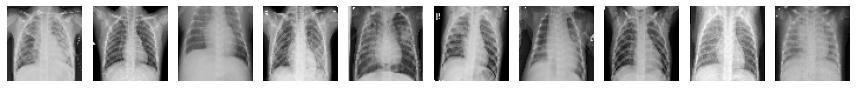

In [14]:
show_images(train_images)

In [15]:
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
valid_img = valid_images.reshape(valid_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(valid_img.shape)

(3271, 12288)
(1751, 12288)
(816, 12288)


In [16]:
train_y = np.reshape(train_labels[:,0], (train_size,1))
test_y = np.reshape(test_labels[:,0], (test_size,1))
valid_y = np.reshape(valid_labels[:,0], (validation_size,1))

print(train_y.shape)
print(test_y.shape)
print(valid_y.shape)

(3271, 1)
(1751, 1)
(816, 1)


## Baseline Model

In [17]:
# Build a baseline fully connected model
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(12288,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Epoch 1/15
103/103 [==============================] - 1s 3ms/step - loss: 0.5303 - accuracy: 0.7307
Epoch 2/15
103/103 [==============================] - 2s 15ms/step - loss: 0.4145 - accuracy: 0.7814
Epoch 3/15
103/103 [==============================] - 2s 18ms/step - loss: 0.3554 - accuracy: 0.8646
Epoch 4/15
103/103 [==============================] - 2s 20ms/step - loss: 0.3384 - accuracy: 0.8762
Epoch 5/15
103/103 [==============================] - 2s 20ms/step - loss: 0.3204 - accuracy: 0.8896
Epoch 6/15
103/103 [==============================] - 2s 21ms/step - loss: 0.3141 - accuracy: 0.8872
Epoch 7/15
103/103 [==============================] - 0s 3ms/step - loss: 0.2739 - accuracy: 0.9138
Epoch 8/15
103/103 [==============================] - 1s 13ms/step - loss: 0.2825 - accuracy: 0.9028 0s - loss: 0.2740 - ac
Epoch 9/15
103/103 [==============================] - 3s 29ms/step - loss: 0.2609 - accuracy: 0.9135
Epoch 10/15
103/103 [==============================] - 3s 28ms/step - 

<AxesSubplot:>

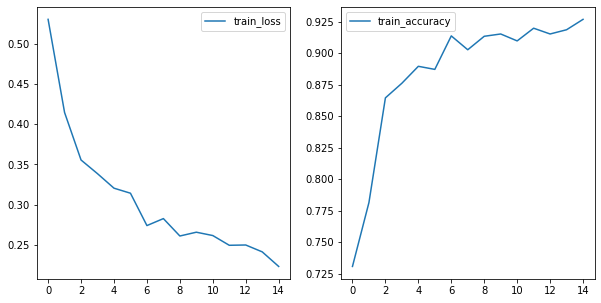

In [18]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

baseline = model.fit(train_img, train_y,epochs=15, batch_size=32) 

train_loss = baseline.history['loss']
train_acc = baseline.history['accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=baseline.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=baseline.epoch, y=train_acc, ax=ax2, label='train_accuracy')

### SkLearn Version for Cross-Validation

In [19]:
# Build function that builds the model so we can evaluate in sklearn
def build_model():
    model.add(layers.Dense(20, activation='relu', input_shape=(12288,))) # 2 hidden layers
    model.add(layers.Dense(7, activation='relu'))
    model.add(layers.Dense(5, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

    return model

In [20]:
keras_model = scikit_learn.KerasClassifier(build_model,
                                          epochs=15,
                                          batch_size=32,
                                          verbose=2)

### Cross-Validation

In [21]:
# Now that it is a keras model, you can cross-validate it
cvs = cross_val_score(keras_model, train_img, train_y, cv=5)

Epoch 1/15
82/82 - 1s - loss: 0.6411 - accuracy: 0.8356
Epoch 2/15
82/82 - 0s - loss: 0.5714 - accuracy: 0.7255
Epoch 3/15
82/82 - 2s - loss: 0.5260 - accuracy: 0.7255
Epoch 4/15
82/82 - 2s - loss: 0.4847 - accuracy: 0.7255
Epoch 5/15
82/82 - 3s - loss: 0.4433 - accuracy: 0.7255
Epoch 6/15
82/82 - 1s - loss: 0.3987 - accuracy: 0.8402
Epoch 7/15
82/82 - 0s - loss: 0.3577 - accuracy: 0.9373
Epoch 8/15
82/82 - 0s - loss: 0.3210 - accuracy: 0.9362
Epoch 9/15
82/82 - 0s - loss: 0.2865 - accuracy: 0.9350
Epoch 10/15
82/82 - 0s - loss: 0.2727 - accuracy: 0.9205
Epoch 11/15
82/82 - 0s - loss: 0.2415 - accuracy: 0.9346
Epoch 12/15
82/82 - 1s - loss: 0.2358 - accuracy: 0.9297
Epoch 13/15
82/82 - 2s - loss: 0.2344 - accuracy: 0.9201
Epoch 14/15
82/82 - 1s - loss: 0.2304 - accuracy: 0.9220
Epoch 15/15
82/82 - 2s - loss: 0.2061 - accuracy: 0.9262
21/21 - 0s - loss: 0.1962 - accuracy: 0.9374
Epoch 1/15
82/82 - 1s - loss: 0.6662 - accuracy: 0.7298
Epoch 2/15
82/82 - 0s - loss: 0.6184 - accuracy: 0.72

### Results

In [22]:
results_train = model.evaluate(train_img, train_y)

103/103 [==============================] - 2s 19ms/step - loss: 0.5829 - accuracy: 0.7304


In [23]:
results_test = model.evaluate(test_img, test_y)

55/55 [==============================] - 1s 26ms/step - loss: 0.5834 - accuracy: 0.7299


In [24]:
save_result('Initial Model', results_train[1], results_test[1], cvs[0], cvs[1], cvs[2], cvs[3], cvs[4])

,model_name,Train Accuracy,Test Accuracy,CV1,CV2,CV3,CV4,CV5,CV_Std,CV_avg
0,Initial Model,0.73,0.73,0.937,0.732,0.735,0.709,0.725,0.095,0.768


## Convolutional Neural Network (CNN)

In [25]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))  
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        16416     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)             

In [27]:
model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

### Train Initial Simple CNN

In [28]:
cnn_1 = model.fit(train_images,
                    train_y,
                    epochs=25,
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size)

Epoch 1/25
103/103 [==============================] - 5s 40ms/step - loss: 0.5833 - accuracy: 0.7307 - val_loss: 0.5686 - val_accuracy: 0.7304
Epoch 2/25
103/103 [==============================] - 4s 41ms/step - loss: 0.5507 - accuracy: 0.7307 - val_loss: 0.5088 - val_accuracy: 0.7304
Epoch 3/25
103/103 [==============================] - 4s 39ms/step - loss: 0.4919 - accuracy: 0.7615 - val_loss: 0.7125 - val_accuracy: 0.7304
Epoch 4/25
103/103 [==============================] - 4s 39ms/step - loss: 0.4252 - accuracy: 0.8178 - val_loss: 0.4001 - val_accuracy: 0.7733
Epoch 5/25
103/103 [==============================] - 4s 39ms/step - loss: 0.3494 - accuracy: 0.8563 - val_loss: 0.2769 - val_accuracy: 0.8787
Epoch 6/25
103/103 [==============================] - 4s 39ms/step - loss: 0.2945 - accuracy: 0.8731 - val_loss: 0.2413 - val_accuracy: 0.9044
Epoch 7/25
103/103 [==============================] - 4s 40ms/step - loss: 0.2560 - accuracy: 0.8912 - val_loss: 0.2123 - val_accuracy: 0.9093

In [29]:
results_train = model.evaluate(train_images, train_y)

103/103 [==============================] - 1s 11ms/step - loss: 0.1365 - accuracy: 0.9468 0s - loss: 0.1292 - accuracy


In [30]:
results_test = model.evaluate(test_images, test_y)

55/55 [==============================] - 1s 10ms/step - loss: 0.1720 - accuracy: 0.9315


### Prediction for Confusion Matrix

In [125]:
predictions = model.predict(x = test_images, steps = 10, verbose=0)

In [126]:
pred_check = np.round(predictions)

In [127]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [128]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [129]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

In [130]:
cm

array([[1234,   44],
       [  76,  397]], dtype=int64)

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

In [38]:
{'normal': 0, 'pneumonia': 1}

{'normal': 0, 'pneumonia': 1}

Confusion matrix, without normalization
[[1234   44]
 [  76  397]]


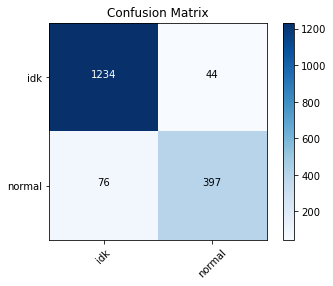

In [39]:
cm_plot_labels = ['idk', 'normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### CNN #1 Results



<AxesSubplot:>

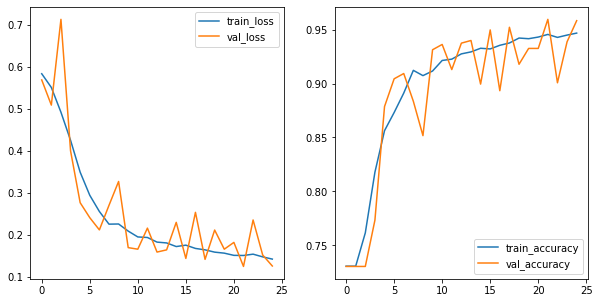

In [40]:
train_loss = cnn_1.history['loss']
train_acc = cnn_1.history['accuracy']
val_loss = cnn_1.history['val_loss']
val_acc = cnn_1.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=cnn_1.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=cnn_1.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=cnn_1.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=cnn_1.epoch, y=val_acc, ax=ax2, label='val_accuracy')


In [41]:

def build_cnn():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64 ,64,  3)))  
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))        #Last layer must be 1 for binary classification 

    model.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=['accuracy'])

    return model

In [42]:
keras_model2 = scikit_learn.KerasClassifier(build_cnn,
                                            epochs=25,
                                            validation_data=(valid_images, valid_y),
                                            validation_steps = validation_size)

In [43]:
# Now that it is a keras model, you can cross-validate it
cvs = cross_val_score(keras_model2, train_images , train_y, cv=5)

Epoch 1/25
82/82 [==============================] - 4s 46ms/step - loss: 0.5851 - accuracy: 0.7255 - val_loss: 0.5692 - val_accuracy: 0.7304
Epoch 2/25
82/82 [==============================] - 3s 41ms/step - loss: 0.5613 - accuracy: 0.7255 - val_loss: 0.5381 - val_accuracy: 0.7304
Epoch 3/25
82/82 [==============================] - 3s 40ms/step - loss: 0.5239 - accuracy: 0.7343 - val_loss: 0.4728 - val_accuracy: 0.7304
Epoch 4/25
82/82 [==============================] - 3s 40ms/step - loss: 0.4602 - accuracy: 0.7878 - val_loss: 0.5395 - val_accuracy: 0.7402
Epoch 5/25
82/82 [==============================] - 3s 40ms/step - loss: 0.4155 - accuracy: 0.8131 - val_loss: 0.3630 - val_accuracy: 0.8113
Epoch 6/25
82/82 [==============================] - 3s 40ms/step - loss: 0.3353 - accuracy: 0.8547 - val_loss: 0.2638 - val_accuracy: 0.8922
Epoch 7/25
82/82 [==============================] - 3s 40ms/step - loss: 0.3009 - accuracy: 0.8758 - val_loss: 0.2414 - val_accuracy: 0.8983
Epoch 8/25
82

In [44]:
save_result('CNN #1', results_train[1], results_test[1], cvs[0], cvs[1], cvs[2], cvs[3], cvs[4])

,model_name,Train Accuracy,Test Accuracy,CV1,CV2,CV3,CV4,CV5,CV_Std,CV_avg
0,CNN #1,0.947,0.931,0.933,0.943,0.934,0.943,0.917,0.011,0.934
0,Initial Model,0.730,0.730,0.937,0.732,0.735,0.709,0.725,0.095,0.768


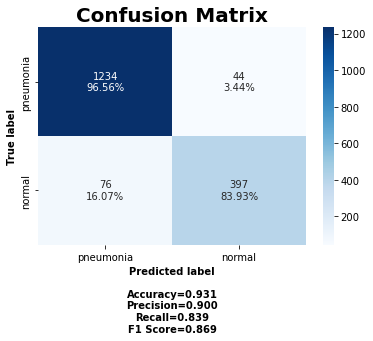

In [133]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

# CNN Model 2

For this model, I added another round of Conv2D and MaxPooling layers, and changed the optimizer to "adam"

In [45]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))  
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(32, (4, 4), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(96, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [46]:
history2 = model2.fit(train_images,
                    train_y,
                    epochs=50,
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size)

Epoch 1/50
103/103 [==============================] - 5s 43ms/step - loss: 0.4916 - accuracy: 0.7710 - val_loss: 0.2972 - val_accuracy: 0.8738
Epoch 2/50
103/103 [==============================] - 4s 41ms/step - loss: 0.2453 - accuracy: 0.8948 - val_loss: 0.1695 - val_accuracy: 0.9301
Epoch 3/50
103/103 [==============================] - 4s 42ms/step - loss: 0.1757 - accuracy: 0.9309 - val_loss: 0.1237 - val_accuracy: 0.9559
Epoch 4/50
103/103 [==============================] - 5s 48ms/step - loss: 0.1339 - accuracy: 0.9468 - val_loss: 0.1083 - val_accuracy: 0.9632
Epoch 5/50
103/103 [==============================] - 4s 43ms/step - loss: 0.1274 - accuracy: 0.9514 - val_loss: 0.1092 - val_accuracy: 0.9510
Epoch 6/50
103/103 [==============================] - 4s 42ms/step - loss: 0.1194 - accuracy: 0.9544 - val_loss: 0.1070 - val_accuracy: 0.9608
Epoch 7/50
103/103 [==============================] - 4s 42ms/step - loss: 0.1136 - accuracy: 0.9590 - val_loss: 0.1119 - val_accuracy: 0.9522

In [47]:
results_train = model2.evaluate(train_images, train_y)

103/103 [==============================] - 1s 11ms/step - loss: 1.7580e-05 - accuracy: 1.0000


In [48]:
results_test = model2.evaluate(test_images, test_y)

55/55 [==============================] - 1s 11ms/step - loss: 0.3307 - accuracy: 0.9486


<AxesSubplot:>

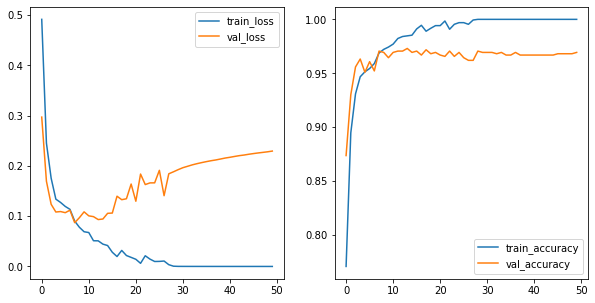

In [49]:
train_loss = history2.history['loss']
train_acc = history2.history['accuracy']
val_loss = history2.history['val_loss']
val_acc = history2.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=history2.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=history2.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=history2.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=history2.epoch, y=val_acc, ax=ax2, label='val_accuracy')

In [50]:
def build_cnn2():
    model2 = models.Sequential()
    model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64 ,64,  3)))  
    model2.add(layers.MaxPooling2D((2, 2)))

    model2.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model2.add(layers.MaxPooling2D((2, 2)))
    
    model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D((2, 2)))

    model2.add(layers.Conv2D(96, (3, 3), activation='relu'))
    model2.add(layers.MaxPooling2D((2, 2)))

    model2.add(layers.Flatten())
    model2.add(layers.Dense(64, activation='relu'))
    model2.add(layers.Dense(1, activation='sigmoid'))

    model2.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

    return model2

In [51]:
keras_model3 = scikit_learn.KerasClassifier(build_cnn2,
                                            epochs=50,
                                            validation_data=(valid_images, valid_y),
                                            validation_steps = validation_size)

In [52]:
cvs = cross_val_score(keras_model3, train_images , train_y, cv=5)

Epoch 1/50
82/82 [==============================] - 4s 45ms/step - loss: 0.5400 - accuracy: 0.7416 - val_loss: 0.2919 - val_accuracy: 0.8738
Epoch 2/50
82/82 [==============================] - 4s 46ms/step - loss: 0.2888 - accuracy: 0.8758 - val_loss: 0.2811 - val_accuracy: 0.8664
Epoch 3/50
82/82 [==============================] - 4s 44ms/step - loss: 0.2299 - accuracy: 0.9063 - val_loss: 0.2169 - val_accuracy: 0.9142
Epoch 4/50
82/82 [==============================] - 3s 42ms/step - loss: 0.1956 - accuracy: 0.9228 - val_loss: 0.1761 - val_accuracy: 0.9326
Epoch 5/50
82/82 [==============================] - 3s 42ms/step - loss: 0.1626 - accuracy: 0.9362 - val_loss: 0.1402 - val_accuracy: 0.9547
Epoch 6/50
82/82 [==============================] - 3s 42ms/step - loss: 0.1563 - accuracy: 0.9400 - val_loss: 0.1242 - val_accuracy: 0.9657
Epoch 7/50
82/82 [==============================] - 3s 42ms/step - loss: 0.1649 - accuracy: 0.9373 - val_loss: 0.1197 - val_accuracy: 0.9583
Epoch 8/50
82

In [53]:
save_result('CNN #2', results_train[1], results_test[1], cvs[0], cvs[1], cvs[2], cvs[3], cvs[4])

,model_name,Train Accuracy,Test Accuracy,CV1,CV2,CV3,CV4,CV5,CV_Std,CV_avg
0,CNN #2,1.000,0.949,0.957,0.969,0.956,0.965,0.945,0.009,0.958
0,CNN #1,0.947,0.931,0.933,0.943,0.934,0.943,0.917,0.011,0.934
0,Initial Model,0.730,0.730,0.937,0.732,0.735,0.709,0.725,0.095,0.768


### Prediction for Confusion Matrix

In [134]:
predictions = model2.predict(x = test_images, steps = 10, verbose=0)

In [135]:
pred_check = np.round(predictions)

In [136]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [137]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [138]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

Confusion matrix, without normalization
[[1230   48]
 [  42  431]]


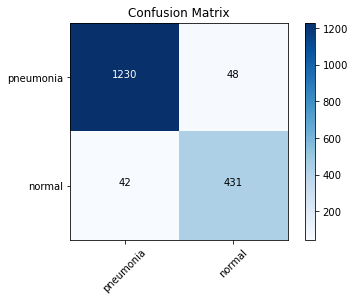

In [139]:
cm_plot_labels = ['pneumonia', 'normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

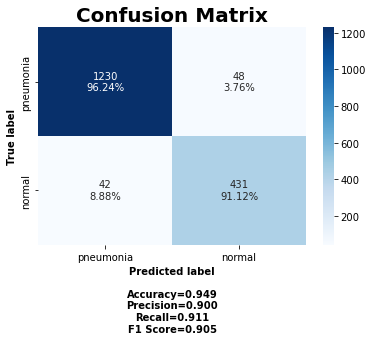

In [140]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

# CNN Model 3

For this model, I add two layers of batch normalization and a 10% dropout. Also added one more layer of Conv2D and MaxPooling.

In [60]:
model3 = models.Sequential()

model3.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
model3.add(BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))

model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization())
model3.add(layers.MaxPooling2D((2, 2)))


model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(Dropout(0.1))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [61]:
model3.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 28, 28, 32)        16416     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 6, 6, 64)        

In [62]:
print(f'trainsize {train_size}, validation size {validation_size}')

trainsize 3271, validation size 816


In [63]:
history3 = model3.fit(train_images,  #Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches
                    train_y,  #Integer or None. Number of samples per gradient update. default to 32. Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches).  
                    #steps_per_epoch = 100,  #The steps per epoch determines how many steps are done before the model is updated.
                    epochs=50,                       # Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached. 
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size)

Epoch 1/50
103/103 [==============================] - 5s 47ms/step - loss: 0.2068 - accuracy: 0.9220 - val_loss: 0.5385 - val_accuracy: 0.7304
Epoch 2/50
103/103 [==============================] - 5s 46ms/step - loss: 0.1576 - accuracy: 0.9416 - val_loss: 0.5346 - val_accuracy: 0.7304
Epoch 3/50
103/103 [==============================] - 5s 45ms/step - loss: 0.1373 - accuracy: 0.9508 - val_loss: 0.2866 - val_accuracy: 0.9485
Epoch 4/50
103/103 [==============================] - 5s 45ms/step - loss: 0.1156 - accuracy: 0.9569 - val_loss: 0.2079 - val_accuracy: 0.9314
Epoch 5/50
103/103 [==============================] - 5s 45ms/step - loss: 0.1116 - accuracy: 0.9609 - val_loss: 0.5114 - val_accuracy: 0.7757
Epoch 6/50
103/103 [==============================] - 5s 46ms/step - loss: 0.0881 - accuracy: 0.9667 - val_loss: 0.1449 - val_accuracy: 0.9473
Epoch 7/50
103/103 [==============================] - 5s 44ms/step - loss: 0.0742 - accuracy: 0.9765 - val_loss: 0.2381 - val_accuracy: 0.9154

In [64]:
results_train = model3.evaluate(train_images, train_y)

103/103 [==============================] - 1s 12ms/step - loss: 6.3973e-04 - accuracy: 1.0000


In [65]:
results_test = model3.evaluate(test_images, test_y)

55/55 [==============================] - 1s 11ms/step - loss: 0.2682 - accuracy: 0.9475


In [66]:
results_train

[0.0006397273973561823, 1.0]

In [67]:
results_test

[0.26823556423187256, 0.9474586248397827]

<AxesSubplot:>

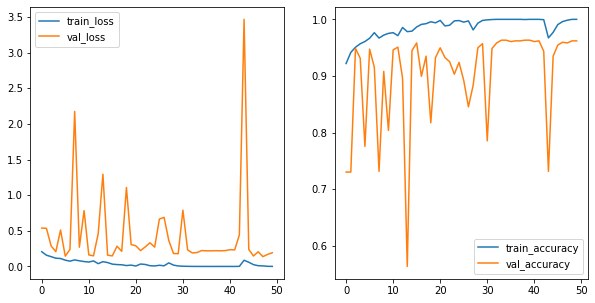

In [68]:
train_loss = history3.history['loss']
train_acc = history3.history['accuracy']
val_loss = history3.history['val_loss']
val_acc = history3.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=history3.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=history3.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=history3.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=history3.epoch, y=val_acc, ax=ax2, label='val_accuracy')

In [69]:
def build_cnn3():
    model3 = models.Sequential()

    model3.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
    model3.add(layers.MaxPooling2D((2, 2)))

    model3.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model3.add(BatchNormalization())
    model3.add(layers.MaxPooling2D((2, 2)))

    model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model3.add(layers.MaxPooling2D((2, 2)))

    model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model3.add(BatchNormalization())
    model3.add(layers.MaxPooling2D((2, 2)))


    model3.add(layers.Flatten())
    model3.add(layers.Dense(64, activation='relu'))
    model3.add(Dropout(0.1))
    model3.add(layers.Dense(1, activation='sigmoid'))

    model3.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model3

In [70]:
keras_model4 = scikit_learn.KerasClassifier(build_cnn3,
                                            epochs=50,                       # Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided (unless the steps_per_epoch flag is set to something other than None). Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached. 
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size)

In [71]:
cvs = cross_val_score(keras_model4, train_images , train_y, cv=5)

Epoch 1/50
82/82 [==============================] - 5s 50ms/step - loss: 0.2359 - accuracy: 0.9136 - val_loss: 0.5173 - val_accuracy: 0.7304
Epoch 2/50
82/82 [==============================] - 4s 48ms/step - loss: 0.1394 - accuracy: 0.9476 - val_loss: 0.6349 - val_accuracy: 0.7304
Epoch 3/50
82/82 [==============================] - 4s 49ms/step - loss: 0.1302 - accuracy: 0.9549 - val_loss: 0.5756 - val_accuracy: 0.7414
Epoch 4/50
82/82 [==============================] - 4s 47ms/step - loss: 0.1256 - accuracy: 0.9576 - val_loss: 0.3394 - val_accuracy: 0.7990
Epoch 5/50
82/82 [==============================] - 4s 48ms/step - loss: 0.1178 - accuracy: 0.9587 - val_loss: 0.2045 - val_accuracy: 0.9179
Epoch 6/50
82/82 [==============================] - 4s 48ms/step - loss: 0.0919 - accuracy: 0.9633 - val_loss: 0.2068 - val_accuracy: 0.9179
Epoch 7/50
82/82 [==============================] - 4s 48ms/step - loss: 0.0761 - accuracy: 0.9721 - val_loss: 0.1113 - val_accuracy: 0.9608
Epoch 8/50
82

In [72]:
save_result('CNN #3', results_train[1], results_test[1], cvs[0], cvs[1], cvs[2], cvs[3], cvs[4])

,model_name,Train Accuracy,Test Accuracy,CV1,CV2,CV3,CV4,CV5,CV_Std,CV_avg
0,CNN #3,1.000,0.947,0.957,0.969,0.957,0.965,0.948,0.008,0.959
0,CNN #2,1.000,0.949,0.957,0.969,0.956,0.965,0.945,0.009,0.958
0,CNN #1,0.947,0.931,0.933,0.943,0.934,0.943,0.917,0.011,0.934
0,Initial Model,0.730,0.730,0.937,0.732,0.735,0.709,0.725,0.095,0.768


### Prediction for Confusion Matrix

In [141]:
predictions = model3.predict(x = test_images, steps = 10, verbose=0)

In [142]:
pred_check = np.round(predictions)

In [143]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [144]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [145]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

Confusion matrix, without normalization
[[1226   52]
 [  40  433]]


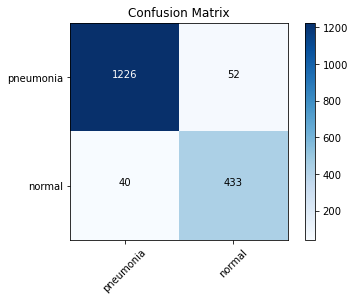

In [146]:
cm_plot_labels = ['pneumonia', 'normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

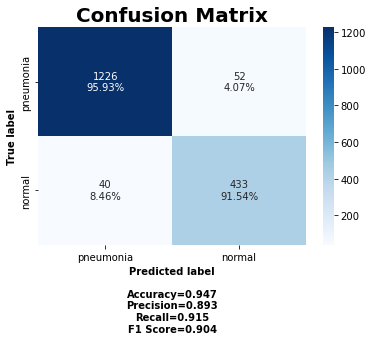

In [147]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

# CNN Model 4

For this model, I will add weights

In [79]:
norm_tot = len(os.listdir('re-split_data/train/normal'))
pneu_tot = len(os.listdir('re-split_data/train/pneumonia'))
norm_weight = norm_tot / (norm_tot + pneu_tot)
pneu_weight = pneu_tot / (norm_tot + pneu_tot)

print(f' normal weight is {round(norm_weight,2)}, pneumonia weight is {round(pneu_weight,2)}')

 normal weight is 0.27, pneumonia weight is 0.73


In [80]:
classWeight = {0 : norm_weight, 1 : pneu_weight}

In [81]:
model4 = models.Sequential()

model4.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
model4.add(BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))

model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(BatchNormalization())
model4.add(layers.MaxPooling2D((2, 2)))


model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(Dropout(0.1))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [82]:
history4 = model4.fit(train_images,
                    train_y,
                    epochs=50,
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size,
                    class_weight=classWeight)

Epoch 1/50
103/103 [==============================] - 5s 47ms/step - loss: 0.0964 - accuracy: 0.9040 - val_loss: 0.5668 - val_accuracy: 0.7304
Epoch 2/50
103/103 [==============================] - 5s 44ms/step - loss: 0.0759 - accuracy: 0.9236 - val_loss: 0.5885 - val_accuracy: 0.6789
Epoch 3/50
103/103 [==============================] - 5s 45ms/step - loss: 0.0592 - accuracy: 0.9431 - val_loss: 0.2302 - val_accuracy: 0.9216
Epoch 4/50
103/103 [==============================] - 5s 44ms/step - loss: 0.0599 - accuracy: 0.9419 - val_loss: 0.6683 - val_accuracy: 0.5699
Epoch 5/50
103/103 [==============================] - 5s 44ms/step - loss: 0.0502 - accuracy: 0.9477 - val_loss: 0.5978 - val_accuracy: 0.7647
Epoch 6/50
103/103 [==============================] - 5s 45ms/step - loss: 0.0486 - accuracy: 0.9566 - val_loss: 0.1500 - val_accuracy: 0.9436
Epoch 7/50
103/103 [==============================] - 5s 44ms/step - loss: 0.0392 - accuracy: 0.9596 - val_loss: 0.1570 - val_accuracy: 0.9350

In [83]:
results_train = model4.evaluate(train_images, train_y)

103/103 [==============================] - 1s 11ms/step - loss: 1.7107e-05 - accuracy: 1.0000


In [84]:
results_test = model4.evaluate(test_images, test_y)

55/55 [==============================] - 1s 11ms/step - loss: 0.3324 - accuracy: 0.9555


In [85]:
results_train

[1.7106991435866803e-05, 1.0]

In [86]:
results_test

[0.3323778510093689, 0.9554540514945984]

<AxesSubplot:>

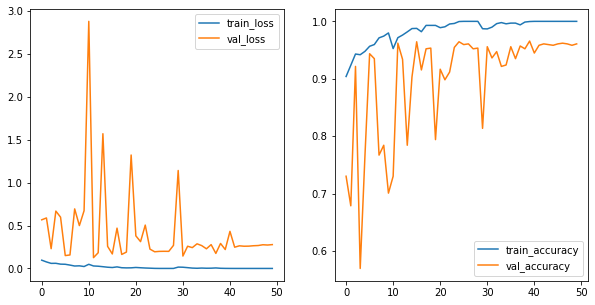

In [87]:
train_loss = history4.history['loss']
train_acc = history4.history['accuracy']
val_loss = history4.history['val_loss']
val_acc = history4.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=history4.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=history4.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=history4.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=history4.epoch, y=val_acc, ax=ax2, label='val_accuracy')

In [88]:
def build_cnn5():
    model4 = models.Sequential()

    model4.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
    model4.add(layers.MaxPooling2D((2, 2)))

    model4.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model4.add(BatchNormalization())
    model4.add(layers.MaxPooling2D((2, 2)))

    model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model4.add(layers.MaxPooling2D((2, 2)))

    model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model4.add(BatchNormalization())
    model4.add(layers.MaxPooling2D((2, 2)))


    model4.add(layers.Flatten())
    model4.add(layers.Dense(64, activation='relu'))
    model4.add(Dropout(0.1))
    model4.add(layers.Dense(1, activation='sigmoid'))

    model4.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model4

In [89]:
keras_model5 = scikit_learn.KerasClassifier(build_cnn5,
                                            epochs=50,
                                            validation_data=(valid_images, valid_y),
                                            validation_steps = validation_size)

In [90]:
cvs = cross_val_score(keras_model5, train_images , train_y, cv=5)

Epoch 1/50
82/82 [==============================] - 5s 48ms/step - loss: 0.2341 - accuracy: 0.9071 - val_loss: 0.6040 - val_accuracy: 0.7463
Epoch 2/50
82/82 [==============================] - 4s 47ms/step - loss: 0.1642 - accuracy: 0.9381 - val_loss: 0.7065 - val_accuracy: 0.3946
Epoch 3/50
82/82 [==============================] - 4s 46ms/step - loss: 0.1468 - accuracy: 0.9484 - val_loss: 0.5488 - val_accuracy: 0.7034
Epoch 4/50
82/82 [==============================] - 4s 47ms/step - loss: 0.1152 - accuracy: 0.9564 - val_loss: 0.7290 - val_accuracy: 0.5527
Epoch 5/50
82/82 [==============================] - 4s 47ms/step - loss: 0.0970 - accuracy: 0.9664 - val_loss: 1.4183 - val_accuracy: 0.7304
Epoch 6/50
82/82 [==============================] - 4s 47ms/step - loss: 0.0884 - accuracy: 0.9694 - val_loss: 0.3700 - val_accuracy: 0.8370
Epoch 7/50
82/82 [==============================] - 4s 47ms/step - loss: 0.0963 - accuracy: 0.9660 - val_loss: 0.2322 - val_accuracy: 0.8909
Epoch 8/50
82

In [91]:
save_result('CNN #4', results_train[1], results_test[1], cvs[0], cvs[1], cvs[2], cvs[3], cvs[4])

,model_name,Train Accuracy,Test Accuracy,CV1,CV2,CV3,CV4,CV5,CV_Std,CV_avg
0,CNN #4,1.000,0.955,0.963,0.972,0.953,0.965,0.950,0.009,0.961
0,CNN #3,1.000,0.947,0.957,0.969,0.957,0.965,0.948,0.008,0.959
0,CNN #2,1.000,0.949,0.957,0.969,0.956,0.965,0.945,0.009,0.958
0,CNN #1,0.947,0.931,0.933,0.943,0.934,0.943,0.917,0.011,0.934
0,Initial Model,0.730,0.730,0.937,0.732,0.735,0.709,0.725,0.095,0.768


In [149]:
predictions = model4.predict(x = test_images, steps = 10, verbose=0)

In [150]:
pred_check = np.round(predictions)

In [151]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [152]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [153]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

Confusion matrix, without normalization
[[1236   42]
 [  36  437]]


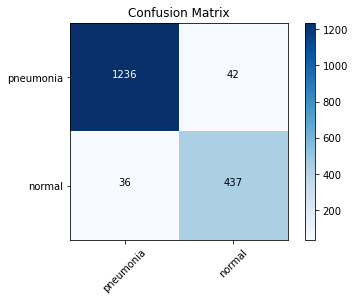

In [154]:
cm_plot_labels = ['pneumonia', 'normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

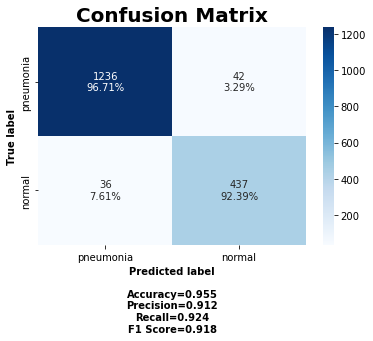

In [155]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

## CNN Model 5: Model 3 with added layer

After observing how the first five models ran,  CNN #2 was the best model due to low standard deviation for the cross validation and high test and train accuracy. I will try adding dropout to help the little bit of overtraining that is occuring

In [98]:
model6 = models.Sequential()

model6.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Conv2D(32, (4, 4), activation='relu'))
model6.add(BatchNormalization())
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Conv2D(64, (3, 3), activation='relu'))
model6.add(BatchNormalization())
model6.add(layers.MaxPooling2D((2, 2)))

model6.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))  # new
model6.add(BatchNormalization())                                        # new    
model6.add(Dropout(0.1))                                                # new                   
model6.add(layers.MaxPooling2D((2, 2)))                                     # new

model6.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model6.add(BatchNormalization())
model6.add(layers.MaxPooling2D((2, 2)))


model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation='relu'))
model6.add(Dropout(0.1))
model6.add(layers.Dense(1, activation='sigmoid'))

model6.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [99]:
history6 = model6.fit(train_images,
                    train_y,
                    epochs=50,
                    validation_data=(valid_images, valid_y),
                    validation_steps = validation_size)

Epoch 1/50
103/103 [==============================] - 6s 52ms/step - loss: 0.2311 - accuracy: 0.9089 - val_loss: 1.0388 - val_accuracy: 0.7304
Epoch 2/50
103/103 [==============================] - 5s 48ms/step - loss: 0.1591 - accuracy: 0.9395 - val_loss: 1.2372 - val_accuracy: 0.7304
Epoch 3/50
103/103 [==============================] - 5s 49ms/step - loss: 0.1301 - accuracy: 0.9514 - val_loss: 0.4789 - val_accuracy: 0.7623
Epoch 4/50
103/103 [==============================] - 5s 49ms/step - loss: 0.1148 - accuracy: 0.9584 - val_loss: 1.4005 - val_accuracy: 0.7341
Epoch 5/50
103/103 [==============================] - 5s 49ms/step - loss: 0.1077 - accuracy: 0.9612 - val_loss: 1.1663 - val_accuracy: 0.7304
Epoch 6/50
103/103 [==============================] - 5s 51ms/step - loss: 0.0958 - accuracy: 0.9642 - val_loss: 1.0817 - val_accuracy: 0.4498
Epoch 7/50
103/103 [==============================] - 5s 49ms/step - loss: 0.0840 - accuracy: 0.9673 - val_loss: 0.1275 - val_accuracy: 0.9534

In [100]:
results_train = model6.evaluate(train_images, train_y)

103/103 [==============================] - 1s 12ms/step - loss: 0.1507 - accuracy: 0.9389


In [101]:
results_test = model6.evaluate(test_images, test_y)

55/55 [==============================] - 1s 12ms/step - loss: 0.4150 - accuracy: 0.8932


<AxesSubplot:>

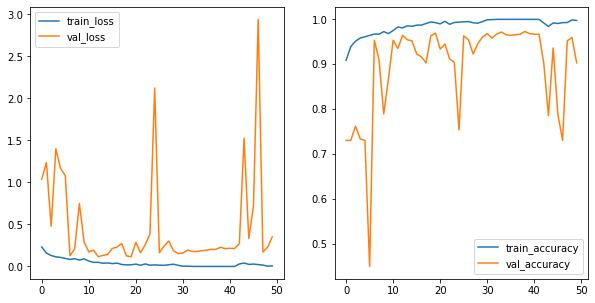

In [102]:
train_loss = history6.history['loss']
train_acc = history6.history['accuracy']
val_loss = history6.history['val_loss']
val_acc = history6.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=history6.epoch, y=train_loss, ax=ax1, label='train_loss')
sns.lineplot(x=history6.epoch, y=train_acc, ax=ax2, label='train_accuracy')
sns.lineplot(x=history6.epoch, y=val_loss, ax=ax1, label='val_loss')
sns.lineplot(x=history6.epoch, y=val_acc, ax=ax2, label='val_accuracy')

In [103]:
def build_cnn6():
    model6 = models.Sequential()

    model6.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(64 ,64,  3)))  
    model6.add(layers.MaxPooling2D((2, 2)))

    model6.add(layers.Conv2D(32, (4, 4), activation='relu'))
    model6.add(BatchNormalization())
    model6.add(layers.MaxPooling2D((2, 2)))

    model6.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model6.add(BatchNormalization())
    model6.add(layers.MaxPooling2D((2, 2)))

    model6.add(layers.Conv2D(96, (3, 3), activation='relu', padding='same'))  # new
    model6.add(BatchNormalization())                                        # new    
    model6.add(Dropout(0.1))                                                # new                   
    model6.add(layers.MaxPooling2D((2, 2)))                                     # new

    model6.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model6.add(BatchNormalization())
    model6.add(layers.MaxPooling2D((2, 2)))


    model6.add(layers.Flatten())
    model6.add(layers.Dense(64, activation='relu'))
    model6.add(Dropout(0.1))
    model6.add(layers.Dense(1, activation='sigmoid'))

    model6.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

    return model6

In [104]:
keras_model6 = scikit_learn.KerasClassifier(build_cnn6,
                                            epochs=50,
                                            validation_data=(valid_images, valid_y),
                                            validation_steps = validation_size)

In [105]:
cvs = cross_val_score(keras_model6, train_images , train_y, cv=5)

Epoch 1/50
82/82 [==============================] - 6s 56ms/step - loss: 0.2369 - accuracy: 0.9083 - val_loss: 0.5335 - val_accuracy: 0.7304
Epoch 2/50
82/82 [==============================] - 4s 53ms/step - loss: 0.1652 - accuracy: 0.9411 - val_loss: 1.1278 - val_accuracy: 0.7304
Epoch 3/50
82/82 [==============================] - 4s 53ms/step - loss: 0.1388 - accuracy: 0.9507 - val_loss: 0.6078 - val_accuracy: 0.7304
Epoch 4/50
82/82 [==============================] - 4s 53ms/step - loss: 0.1183 - accuracy: 0.9560 - val_loss: 0.3297 - val_accuracy: 0.8603
Epoch 5/50
82/82 [==============================] - 4s 53ms/step - loss: 0.1051 - accuracy: 0.9595 - val_loss: 0.4812 - val_accuracy: 0.7782
Epoch 6/50
82/82 [==============================] - 4s 53ms/step - loss: 0.0873 - accuracy: 0.9675 - val_loss: 0.5795 - val_accuracy: 0.8039
Epoch 7/50
82/82 [==============================] - 4s 53ms/step - loss: 0.0739 - accuracy: 0.9721 - val_loss: 0.1368 - val_accuracy: 0.9498
Epoch 8/50
82

In [106]:
save_result('CNN #6', results_train[1], results_test[1], cvs[0], cvs[1], cvs[2], cvs[3], cvs[4])

,model_name,Train Accuracy,Test Accuracy,CV1,CV2,CV3,CV4,CV5,CV_Std,CV_avg
0,CNN #4,1.000,0.955,0.963,0.972,0.953,0.965,0.950,0.009,0.961
0,CNN #3,1.000,0.947,0.957,0.969,0.957,0.965,0.948,0.008,0.959
0,CNN #2,1.000,0.949,0.957,0.969,0.956,0.965,0.945,0.009,0.958
0,CNN #1,0.947,0.931,0.933,0.943,0.934,0.943,0.917,0.011,0.934
0,CNN #6,0.939,0.893,0.890,0.917,0.951,0.804,0.902,0.055,0.893
0,Initial Model,0.730,0.730,0.937,0.732,0.735,0.709,0.725,0.095,0.768


### Prediction for Confusion Matrix

In [107]:
predictions = model6.predict(x = test_images, steps = 10, verbose=0)

In [108]:
pred_check = np.round(predictions)

In [109]:
pred_check = pred_check[:]
pred_check = pred_check.flatten()
pred_check

array([1., 1., 1., ..., 0., 0., 1.], dtype=float32)

In [110]:
test_check = test_labels[:,0]
test_check

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [111]:
cm = confusion_matrix(y_true=test_check, y_pred=pred_check)

Confusion matrix, without normalization
[[1102  176]
 [  11  462]]


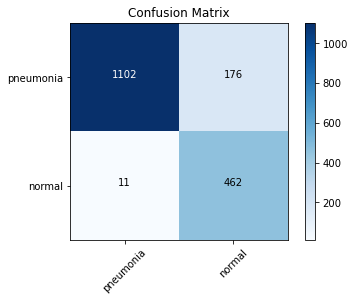

In [112]:
cm_plot_labels = ['pneumonia', 'normal']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [120]:
# SOURCE: The origin of this confusion matrix code was found on medium, '
# from https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            a = cf[0,0]
            b = cf[0,1]
            c = cf[1,0]
            d = cf[1,1]
            tn = ((a / (a+b))*100).round(2).astype(str) + '%'
            fp = ((b / (a+b))*100).round(2).astype(str) + '%'
            fn = ((c / (c+d))*100).round(2).astype(str) + '%'
            tp = ((d / (c+d))*100).round(2).astype(str) + '%'
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            rwf_score = 2*precision* (recall*2) /(precision + (recall*2))
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}\n\nRecall-Weighted F Score={:0.3f}".format(
                accuracy,precision,recall,f1_score, rwf_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages =  [tn,fp,fn,tp]
        # old = group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label', weight = 'bold')
        plt.xlabel('Predicted label' + stats_text, weight = 'bold')
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title,size = 20, weight = 'bold')

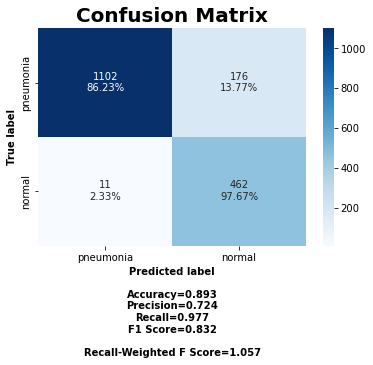

In [124]:
cm_plot_labels = ['pneumonia', 'normal']
make_confusion_matrix(cm, categories = cm_plot_labels, title='Confusion Matrix')

## Conclusion

I was unable to improve performance past CNN #4, making CNN #4 the final model for this project. 



In [119]:
# Model 4 Summary
model4.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 28, 28, 32)        16416     
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 6, 6, 64)        

### Final Results

![](Model4_cm.png)

The final result included 1,236 true positives, 437 true negatives, 36 false negatives, and 42 false positives. 

The total accuracy was 95.5 percent. 

Recall is the number of true positives divided by the total number of elements that actually belong to the positive class -i.e., true positives plus false negatives. 

- Recall equaled  .93.
- Precision equaled .912.
- The F1 Score equaled .918.

In product terms, this means that we could expect the model to correctly pick if an individual has pneumonia based on their x-ray 95.5 percent of the time. 

If I could further this project, I would try other neural network models to see if there is a possibly better techniques for the modeling, such as LIME (locally interpretable model-agnostic explanations). 

I would also attempt further data augmentation. The data augmentation I attempted did not improve the performance of the model, although that portion of the model was cut out for brevity, along with numerous other versions of the CNNs. 

Thank you.